In [1]:
import os
import cv2
import numpy as np
import torch # 1.9
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.nn import functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A

In [2]:
from utils import show_image
from dataset import getAllDataPath, CustomImageDataset
from unet import UNet
from ResUnet import ResUnet

In [3]:
BATCH_SIZE = 12
WIDTH = 256
HEIGHT = 256
device = 'cuda:0'

In [4]:
path = os.getcwd()
img_dir = f'{path}/data/capsule/test/scratch/'
anno_dir = f'{path}/data/capsule/ground_truth/scratch/'


print(f'defective images: {len(os.listdir(img_dir))}')
defect_data = getAllDataPath(img_dir, anno_dir)
print(defect_data.keys())
defect_data['train'][:3]

defective images: 23
dict_keys(['train'])


[('/home/jovyan/Image_Segmentation/03_Models_demo/data/capsule/test/scratch/000.png',
  '/home/jovyan/Image_Segmentation/03_Models_demo/data/capsule/ground_truth/scratch/000_mask.png'),
 ('/home/jovyan/Image_Segmentation/03_Models_demo/data/capsule/test/scratch/001.png',
  '/home/jovyan/Image_Segmentation/03_Models_demo/data/capsule/ground_truth/scratch/001_mask.png'),
 ('/home/jovyan/Image_Segmentation/03_Models_demo/data/capsule/test/scratch/002.png',
  '/home/jovyan/Image_Segmentation/03_Models_demo/data/capsule/ground_truth/scratch/002_mask.png')]

In [5]:
if '__main__' == __name__:
    transform = A.Compose([
        A.CenterCrop(300, 900, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
        A.Rotate((-30, 30), interpolation=0),  

        A.ToFloat(always_apply=True),
        A.Resize(WIDTH, HEIGHT),
    ])

    target_transform = A.Compose([
        A.ToFloat(always_apply=True),
        A.Resize(WIDTH, HEIGHT),
    ])

In [6]:
data = getAllDataPath(img_dir, anno_dir, test_split_size=0.1)
print(data.keys())
# if len(data['train']) < 16: 
#     lis = data['train']
#     lis = [lis[i%len(lis)] for i in range(BATCH_SIZE)]
#     data['train'] = lis

dataset_train = CustomImageDataset(data['train'], transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, drop_last=False,
                                               shuffle=True, pin_memory=True,
                                              )

dataset_test = CustomImageDataset(data['test'], transform=target_transform) # **如果要正式使用要記得把這裡換成X_test
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, drop_last=False,
                                              shuffle=False, pin_memory=True)

dict_keys(['train', 'test'])


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


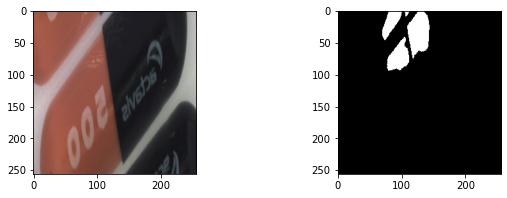

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


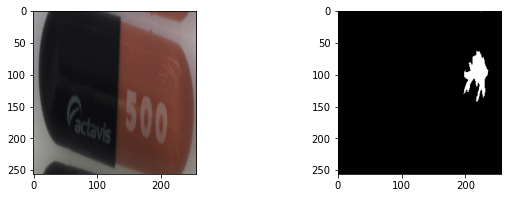

In [7]:
'''
Abs: test transform on dataloader_train.
---
take first image in every batch.
'''
for data in dataloader_train:
    for x, y in zip(*data): 
        print(x.shape, y.shape)
        show_image(x.permute(1,2,0).numpy(), y.squeeze(0).int().numpy())
        break 

In [8]:
import torch
import torch.nn as nn
 
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
 
    def	forward(self, input, target):
        N = target.size(0)
        smooth = 1
 
        input_flat = input.view(N, -1)
        target_flat = target.view(N, -1)
 
        intersection = input_flat * target_flat
 
        loss = (2 * intersection.sum(1) + smooth) / (input_flat.sum(1) + target_flat.sum(1) + smooth)
        loss = 1 - loss.sum() / N
 
        return loss


In [9]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # device = 'cpu' # for debug建議使用cpu作為torch的運行背景
# device

device(type='cuda')

In [10]:
model = UNet
# model = ResUnet

In [11]:
from torchvision.ops import sigmoid_focal_loss
'''
abs: single channel
---
單一通道，二元分類輸出範例
補充:
- 要在建立optimizer之前就把model的參數移到gpu裡面 
ref: https://pytorch.org/docs/stable/optim.html 
'''
model = model(HEIGHT, in_ch=3, out_ch=1, activation=None).to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [12]:
# '''
# abs: Multi channel
# ---
# 輸出多通道，多元分類輸出範例
# 補充:
# - 要在建立optimizer之前就把model的參數移到gpu裡面 

# ref: https://pytorch.org/docs/stable/optim.html 
# '''
# criterion = nn.CrossEntropyLoss().to(device)

# model = model(HEIGHT, in_ch=3, out_ch=2, activation=nn.Sigmoid()).to(device) 

# optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [13]:
'''
abs: training model
---
- 下面的程序會在3種條件下儲存當前的model(只包含weight)
    - 當前模型的loss是目前以來最低
    - 當前epoch數是20的倍數
    - 完成一個epoch的訓練
'''
EPOCHS = 300
min_target_loss_value = 100
save_root = './data/save_weights/'
os.makedirs(save_root, exist_ok=True)
from torchvision.ops import sigmoid_focal_loss

for epoch in range(EPOCHS):  
    class_loss_value = 0.0

    for i, (source_data, source_label) in enumerate(dataloader_train):
        # zero the parameter gradients
        '''
        abs: zero the parameter gradients
        ---
        這兩種方法都能夠清除variable內的gradient:
        方法1
        param in model.parameters():
        param.grad = None
        方法2 借助optimizer尋找關聯的variable並清除gradient
        optimizer.zero_grad()
        '''
        optimizer.zero_grad()
    
        source_data = source_data.to(device)
        source_label = source_label.to(device)

        outputs = model(source_data)
        
#         loss = DiceLoss()(outputs, source_label)
#         loss = torch.nn.MSELoss()(outputs, source_label)
#         loss = torch.nn.BCEWithLogitsLoss()(outputs, source_label)
        loss = sigmoid_focal_loss(outputs, source_label, reduction='sum')
        
        class_loss_value += loss.item()

        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(i, end='\r')
        del source_data, source_label, outputs
        torch.cuda.empty_cache()
    
    class_loss_value /= (i+1)   
    testing_loss_value = class_loss_value

    print(f'epoch: {epoch}, class_loss_value:{class_loss_value}')
    if testing_loss_value < min_target_loss_value:
        min_target_loss_value = testing_loss_value
        print('save best model')
        torch.save(model.state_dict(), f'{save_root}best_model.bin')
    else:
        if epoch%50==49:
            torch.save(model.state_dict(), f'{save_root}E{epoch}_model.bin')
        torch.save(model.state_dict(), f'{save_root}model.bin')
        

epoch: 0, class_loss_value:83963.103515625
epoch: 1, class_loss_value:52773.13671875
epoch: 2, class_loss_value:32923.27734375
epoch: 3, class_loss_value:25297.611328125
epoch: 4, class_loss_value:20799.04296875
epoch: 5, class_loss_value:17634.64013671875
epoch: 6, class_loss_value:15331.025390625
epoch: 7, class_loss_value:13474.56005859375
epoch: 8, class_loss_value:12990.5400390625
epoch: 9, class_loss_value:11297.22802734375
epoch: 10, class_loss_value:10858.46435546875
epoch: 11, class_loss_value:10170.84912109375
epoch: 12, class_loss_value:9590.3583984375
epoch: 13, class_loss_value:8650.0234375
epoch: 14, class_loss_value:7844.20849609375
epoch: 15, class_loss_value:8137.171875
epoch: 16, class_loss_value:7442.470703125
epoch: 17, class_loss_value:7800.41552734375
epoch: 18, class_loss_value:7916.35107421875
epoch: 19, class_loss_value:7003.704345703125
epoch: 20, class_loss_value:6982.056640625
epoch: 21, class_loss_value:7223.009765625
epoch: 22, class_loss_value:7100.583740

12


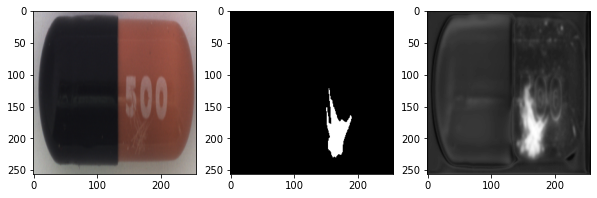

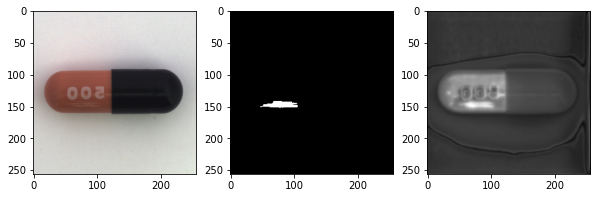

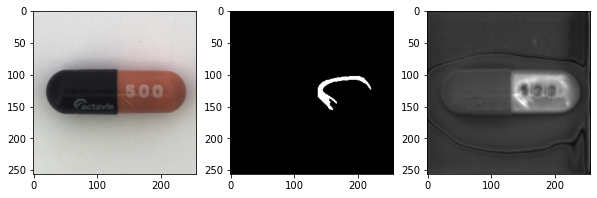

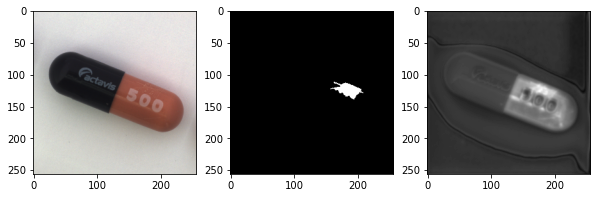

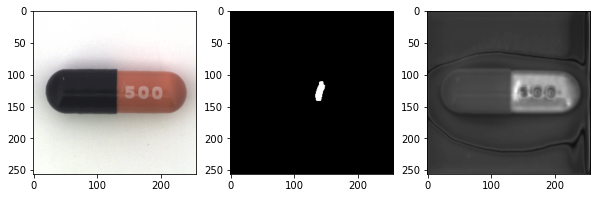

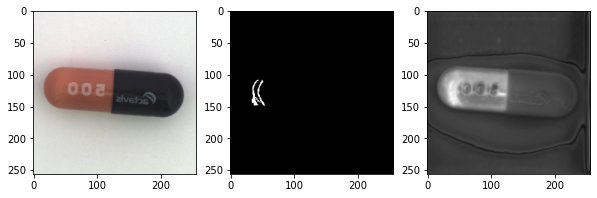

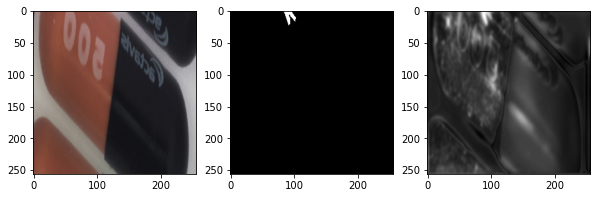

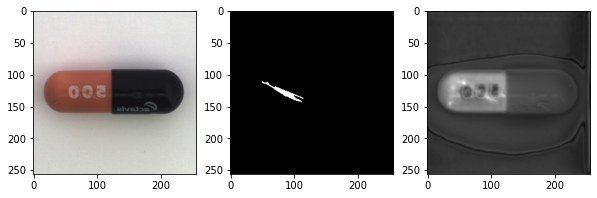

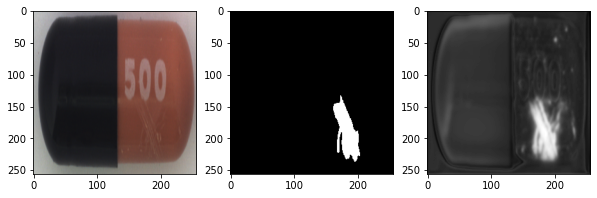

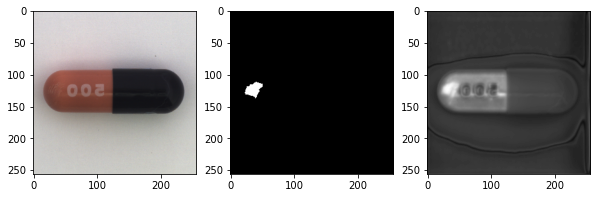

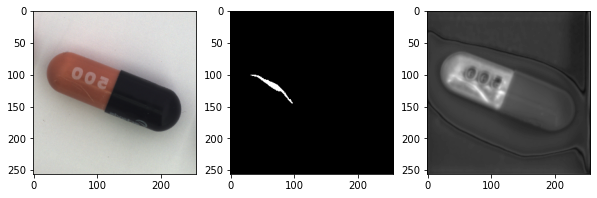

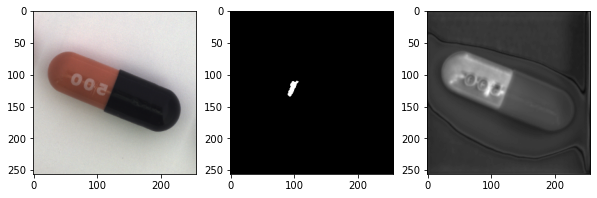

8


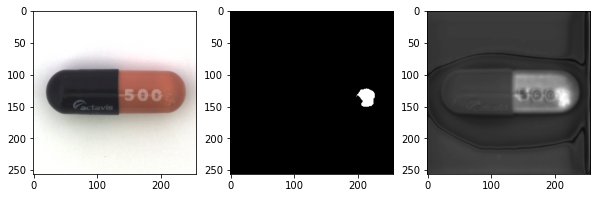

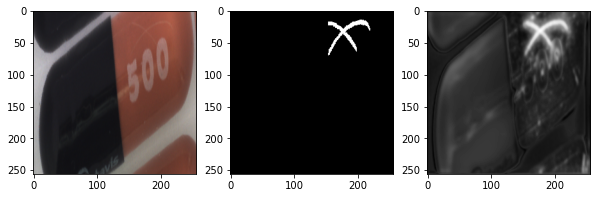

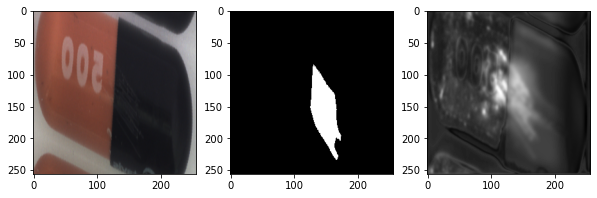

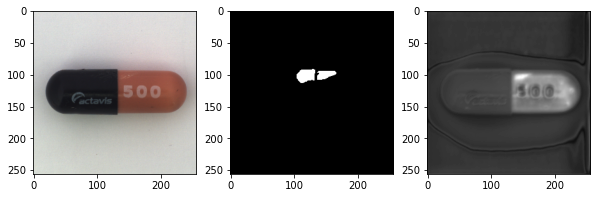

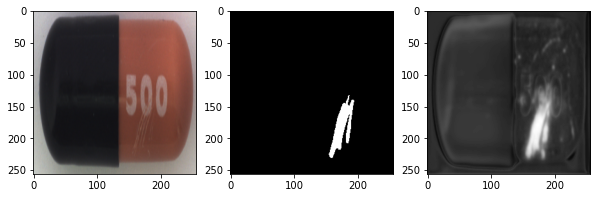

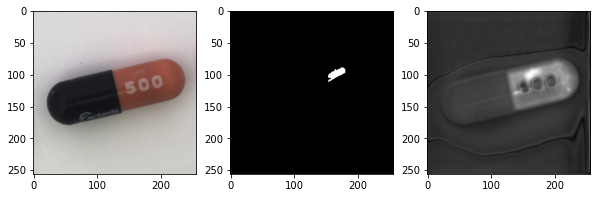

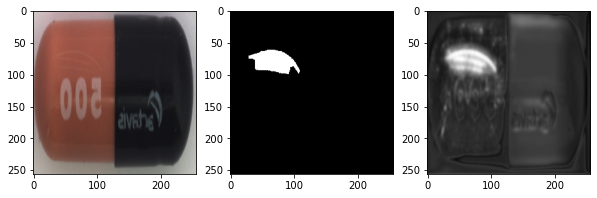

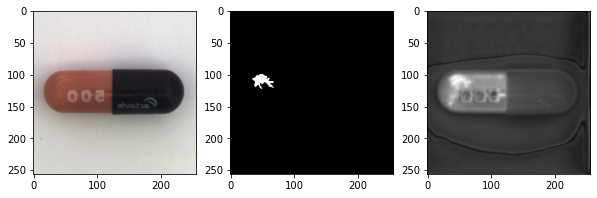

In [14]:
'''
abs: testing model
---
'''

for i, data in enumerate(dataloader_train, 1):
    image, mask = data
    print(len(image))
    with torch.no_grad():
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)
#         outputs = F.sigmoid(outputs)
    loss = DiceLoss()(outputs, mask)
    
    threshold = 0
    outputs[outputs>=threshold] = 1.
    outputs[outputs!=1] = 0.

    img_process = lambda image:image.cpu().permute(0,2,3,1).numpy()
    mask_process = lambda mask:mask.cpu().permute(0,2,3,1).squeeze(-1).numpy()
    
    for x, m, outputs in zip(img_process(image), mask_process(mask), mask_process(outputs)):
        show_image(x, m, outputs)
#         break

In [1]:
import os
from IPython import get_ipython
if __name__ == '__main__':
    if get_ipython().__class__.__name__ =='ZMQInteractiveShell':
        os.system('jupyter nbconvert train_unet.ipynb --to python')

[NbConvertApp] Converting notebook train_unet.ipynb to python
[NbConvertApp] Writing 6701 bytes to train_unet.py
